In [49]:
from numpy import *
from scipy.integrate import quad, dblquad
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time, perf_counter_ns

In [37]:
# setup the field

# the output field for a plane wave of wave number k and
# amplitude A0 passing through
# 1) circular aperture, radius a
# 2) lens f1
# 3) circular aperture radius b
# 4) lens f2

# field returned at radius=r2

TODO: 
* plot axial field from lens f2 onward using eq i derived
* make field input aperture periodic, 1D

In [239]:
## functions

def from_quadrant3(qd3, field=None):
    """
    construct field with rectangular symmetry given only
    quadrant 3 (i.e., field is mirrored across x axis and
    across y axis)
    
    'qd3' 2D numpy array
    Return 'field' 2D numpy array
    """
    
    xpts, ypts = qd3.shape
    xmpt, ympt = int(xpts/2), int(ypts/2)
    
    if field is None:
        field = zeros((2*xpts, 2*ypts))
    
    field[:midpt, :midpt] = qd3
    # qd4
    field[:midpt, midpt:] = flip(qd3, axis=1) 
    # qd1
    field[midpt:, midpt:] = flip(qd3)
    # qd2
    field[midpt:, :midpt] = flip(qd3, axis=0)
    
    return field

def integrand(r1, r2, a, k, f1, f2):
    """output field for 4f Fourier filtered plane wave"""
    return j1(a*r1*k/f1)*j0(r1*r2*k/f2)

def get_meshgrid(w, pts, radial=False):
    midpt = int(pts/2)
    x = linspace(-w, w, pts)
    y = linspace(-w, w, pts)
    xx, yy = meshgrid(x,y, sparse=True)
    if radial:
        rr = sqrt(xx**2 + yy**2)
        return x,midpt,rr
    else:
        return x,midpt,xx,yy

In [ ]:
## physics and system params
k = 2*pi/1.064e-6
A0 = 1
f1 = 0.03
f2 = 1
a = 1e-4 # aperture 1 radius
b = 1e-5 # aperture 2 radius; leave wide for now to see unfiltered beam

In [250]:
## build meshgrid 
w = 6*a # array width 
pts = 1000
    
x,midpt,rr = get_meshgrid(w, pts, radial=True)    

In [277]:
## calculate the field in Fourier plane
A1 = lambda r1: -1j*A0*a*j1(a*r1*k/f1)/r1
qd3 = zeros((midpt, midpt), complex)
for i in range(midpt):
    for j in range(midpt):
        qd3[i,j] = A1(rr[i,j])
field1 = from_quadrant3(abs(qd3))

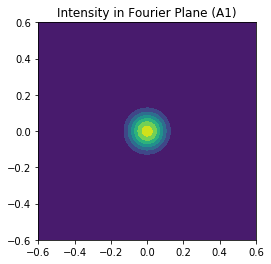

In [278]:
fig,ax = plt.subplots()
I1 = conjugate(field1)*field1
ax.contourf(x*1e3,x*1e3,I1)
ax.set_title('Intensity in Fourier Plane (A1)')
ax.set_aspect('equal')

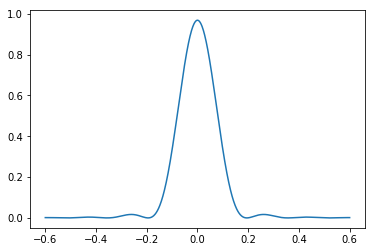

In [281]:
fig, ax= plt.subplots()
ax.plot(x*1e3, I1[midpt,:])

In [285]:
## how much of the field is in that central ring?

# i must be missing something to be getting such a small integral
# result
I1int = lambda r1: r1*(a*A0*j1(a*r1*k/f1)/r1)**2

total = 2*pi*quad(I1int, 0, inf)[0]
print(f'total field {total}') # should be 1
central = 2*pi*quad(I1int, 0, .2)[0]
print(f'central field {central}')

total field 8.652242363869369e-10
central field 5.1395457473227935e-09


In [231]:
## build meshgrid 
w = 6e-6 # array width 
pts = 200
    
x,midpt,rr = get_meshgrid(w, pts, radial=True)    

In [232]:
## calcute the output field in the back focal plane

# calculate only one quadrant, then reflect
field = zeros((pts, pts))
qd3 = field[0:midpt, 0:midpt]

t0 = time()
for i in range(midpt):
    for j in range(midpt):
        args = (rr[i,j], a, k, f1, f2)
        qd3[i,j] = quad(integrand, 0, b, args)[0]
print(f'run time: {time()-t0} [s]')
field = from_quadrant3(qd3, field=field)

run time: 0.8836328983306885 [s]


In [215]:
# field *= -k*A0*a/f2 #

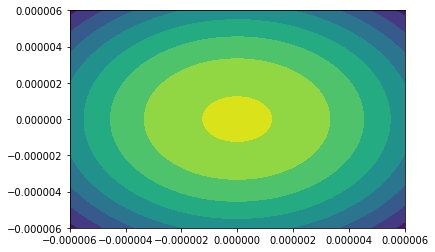

In [233]:
# question: how to get phase of field here? could calculate phase
# using the transfer function on the input field?
# plt.contourf(x*1e6,y*1e6,field**2)
plt.contourf(x, y, field**2)

In [ ]:
plt

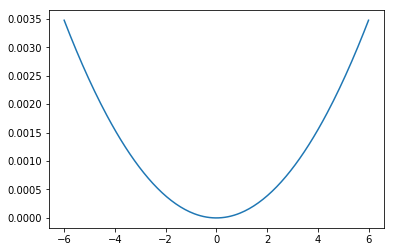

In [229]:
plt.plot(x*1e6,field1[midpt,:]**2)

(-1, 1)

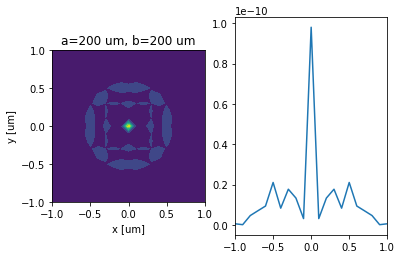

In [81]:
xscl = 1e6
fig, axes = plt.subplots(nrows=1, ncols=2)
ax, ax1 = axes
ax.set_title(f'a=200 um, b=200 um')
ax.set_xlabel('x [um]')
ax.set_ylabel('y [um]')
# for a in axes:
ax.set_aspect('equal')
    
ax.contourf(x*xscl, y*xscl, field**2)
ax1.plot(x*xscl, field[:,int(len(x)/2)]**2)
for a in axes:
    a.set_xlim(-1,1)
ax.set_ylim(-1,1)